In [12]:
%load_ext autoreload
# ???? import numpy
#import Bio
import os
import sys
import requests
# NON from Bio.Blast import NCBIWWW
import xml.etree.ElementTree as XML
import shutil
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# module pyproteins & pyproteinsExt
#sys.path.append("/Users/aheurtel/Documents/Stage/pyproteins/src")
sys.path.append("/home/antoine/Documents/Stage2019/Stage/pyproteins/src")
#sys.path.append("/Users/aheurtel/Documents/Stage/pyproteinsExt/src")
sys.path.append("/home/antoine/Documents/Stage2019/Stage/pyproteinsExt/src")
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/antoine/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/antoine/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/antoine/.ipython',
 '/home/antoine/Documents/Stage2019/Stage/pyproteins/src',
 '/home/antoine/Documents/Stage2019/Stage/pyproteinsExt/src']

In [3]:
import pyproteinsExt.uniprot as uniprot
import pyproteins.sequence.msa as msaLib

In [50]:
%autoreload 2

In [4]:
##                      GlobVAR
#PATH = "/Users/aheurtel/Documents/Protein/"
PATH = "/home/antoine/Documents/Stage2019/Protein/"
# Uniprot
FEAT = ['citation','clusters','comments','domains','domain','ec','id','entry name','existence',
        'families','features','genes','go','go-id','interactor','keywords','last-modified',
        'length','organism','organism-id','pathway','protein names','reviewed','sequence',
        '3d version','virus hosts']
#parameter commun of API
MAIL = 'antoine.heurtel@ibcp.fr'
#WebLogo
#GlobVar pour WebLogo #list establised from https://www.uniprot.org/help/api_queries
TITLE = 'WebLogo'
LEN = 40
DPI = 400
START = 1
BOX = 'yes'
COLOR = 'chemistry'

In [5]:
def makeURL(element,prot):
    '''
    fonction pour creer des url à sousmettre à UniProt
    element sont les info que l'on veut et prot la protein au code uniprot
    '''
    for i in element:
        if i not in FEAT:
            print("L' element "+str(i)+" n'est pas reconnu.")
            print("Choisissez parmi : "+str(FEAT))
    #a faire verif protéine existe
    PROTEIN = prot
    col = ''
    #faire la possibilité ou a est vide if a !='':INFO = '&columns='+INFO
    for i in element:
        col += i+','
    INFO = '&columns='+col[:-1]
    URL = "https://www.uniprot.org/uniprot/?query="+PROTEIN+"&format=tab"+INFO
    return(URL,PROTEIN)

def uniprotInfo(prot, element='', echo = False, xml = False, name = 'uniprot.xml', path = ''):
    if xml:
        if os.path.exists(PATH+prot+'Data/'+name):
            print('file {} already exist, please select a other name.'.format(name))
            return True
        else:
            try:
                f = open(path+name, 'w')
            except FileNotFoundError:
                path = input('Please enter the folder to save your data : ')
                if not path[-1] == '/':
                    path += '/'
                f = open(path+name, 'w')
            webpage = requests.get('https://www.uniprot.org/uniprot/'+prot+'.xml')
            f.write(webpage.text)
            f.close()
            return None
    for i in element:
        if i not in FEAT:
            print("L' element "+str(i)+" n'est pas reconnu.")
            print("Choisissez parmi : "+str(FEAT))
        #a faire verif protéine existe
        PROTEIN = prot
        col = ''
        #faire la possibilité ou a est vide if a !='':INFO = '&columns='+INFO
        for i in element:
            col += i+','
        INFO = '&columns='+col[:-1]
        URL = "https://www.uniprot.org/uniprot/?query="+PROTEIN+"&format=tab"+INFO
        print('from '+URL)
        web = requests.get(URL)
        if echo:
            print(web.text)
            return None
        else:
            return(web.text)

def sequenceUniprot(prot):
    '''
    récupère la séquence d'une protéine depuis internet (uniprot)
    '''
    url = makeURL(['sequence'],prot)
    web = requests.get(url[0])
    return(web.text.split('\n')[1])

def makeDirectory(name):
    if not os.path.exists(PATH+name):
        os.makedirs(PATH+name+'/Data/')
    if not os.path.exists(PATH+name+'/Data/WebLogo'):
        os.makedirs(PATH+name+'/Data/WebLogo')
    return True

def verifSeq(name):
    if os.path.exists(PATH+name+'/Data/uniprot.xml'):
        return True
    else: return False

def writeFile(file, text, path = None):
    """
    fonction pour écrire un fichier dans un path donné si le fichier n'existe pas
    """
    if os.path.exists(path+file) or os.path.exists(path+'/'+file):
        print('already exist')
        return False
    else:
        f = open(path+file,'w')
        f.write(text)
        f.close()

def verifFile(file, ext='', path=''):
    if file == None:
        return False
    for i in file:
        if i == '.' and ext == '':
            ext = file.split('.')[-1]
        elif i == '.' and ext != '':
            pass
        else:
            pass
    if os.path.exists(path+file) or os.path.exists(path+'/'+file):
        return True
    elif os.path.exists(path+file+ext) or os.path.exists(path+'/'+file+ext) or os.path.exists(path+'/'+file+'.'+ext):
        return True
    else:
        return False
        
def litBlast(name):
    """
    mini parser non complet de fichier Blast
    version 0.1
    """
    f = open(name, 'r') 
    exe = False 
    ID = [] 
    for l in f: 
        if exe:
            #print(l) 
            ligne = l.split('.') 
            ID.append(ligne[0]) 
        if 'Sequences' in l: 
            exe = True 
        if 'ALIGNMENTS' in l: 
            exe = False 
            f.close() 
            #ID.remove('ALIGNMENTS') 
            return ID[:-2] 
    f.close()

def unkownUniprot(liste):
    """
    tester la présence d'une séquence dans uniprot
    """
    noMatch = []
    for s in liste:
        #print('Test de '+str(s)) 
        seq = sequenceUniprot(i) 
        if seq == '': 
            print(str(s)+' was not Found') 
            noMatch.append(s)
    print(noMatch)
    return noMatch

def paramWebLogo():
    os.system('weblogo -h')
    global TITLE, LEN, OUT
    
    

## Code python POO

In [234]:
class protein:
    def __init__(self, name):
        '''
        name = protein code accession
        '''
        #self.id = name #on peut créer une fct de vérif de nom
        #self.name = ''
        self.name = name
        if makeDirectory(name):
            self.pwd = PATH+name+'/Data/'
        if not verifSeq(name):
            print('Download uniprot.xml')
            uniprotInfo(name, xml = True, name = 'uniprot.xml', path=self.pwd)
            """
            print('Download sequence')
            sequence = uniprotInfo(name, ['sequence'])# name = protein code uniprot
            self.name = name
            self.seq = sequence
            writeFile('sequence', sequence, PATH+name+'/Data/')
            """
        uniprotColl = uniprot.getUniprotCollection()
        uniprotColl.setCache(location=self.pwd)
        #uniprot.getPfamCollection().setCache(location=self.pwd)
        self.uniprot = uniprotColl.get(name)
        self.seq = self.uniprot.fasta.split('\n')[1]
        self.domains = {}
        self.blastFile = None
        self.homologyFile = None
    
    def scanDomains(self):
        '''
        Traitement du fichier domains.tsv issu de interproScan sur les domaines
        les résultats sont envoyés dans le self.domains : key = ID, comment, Strat, Stop
        '''
        if len(self.domains) > 0:
            print('scan of doamins has done')
            return True
        try:
            print('step 1/2 : searching domains')
            self.domains = open(self.pwd+'domains.tsv','r')
            self.domains.close()
        except IndexError as error:
            print(error)
        except FileNotFoundError:
            url = 'https://www.ebi.ac.uk/interpro/protein/'+self.name+'?export=tsv'
            domainsWeb = requests.get(url)
            codeError = domainsWeb.status_code
            if codeError != 503 or int(codeError/100) != 5 or int(codeError/100) != 4:
                print('Downloading from Uniprot')
                f = open(self.pwd+'domains.tsv', 'w')
                f.write(domainsWeb.text)
                f.close()
            else:
                print('Submitted domains to InterProScan...')
                #parameters for REST InterProScan
                mail = 'antoine.heurtel@ibcp.fr'
                out = self.pwd+'domains'
                ext = 'tsv'
                fasta = self.pwd+'sequence'
                cmd = "python iprscan.py --email "+mail+" --outfile="+out+" --outformat="+ext+" "+fasta
                os.system(cmd)
                os.rename(self.pwd+'domains.tsv.txt', self.pwd+'domains.tsv')
            print('step 2/2 : scanning')
        #Parser
        finally:
            domains = open(self.pwd+'domains.tsv','r')
            self.domains = {}
            for lines in domains.readlines():
                col = lines.split('\t')
                if col[0] == '':
                    break
                elif col[0] == 'Protein Accession':
                    pass
                else:
                    try:
                        #name = col[4]
                        description = col[12]
                        if description == None or description == '':
                            description = col[4]
                    except IndexError:
                        break
                    if description not in self.domains.keys():
                        #self.domains[name] = {} #initname
                        #self.domains[name]['interval'] = []
                        self.domains[description] = {} #initname
                        self.domains[description]['interval'] = []
                    try:
                        #self.domains[name]['is'] = col[12]
                        self.domains[description]['name'] = col[4]
                    except IndexError:
                        #self.domains[name]['is'] = 'NA'
                        description = 'NA'
                        self.domains[description]['name'] = col[4]
                    interval = (col[6],col[7])
                    #self.domains[name]['interval'].append(interval)
                    self.domains[description]['interval'].append(interval)
            domains.close()
            print('scanning finish')
            
    def blast(self):
       #DEBUG
        print('DEBUG MODE\tBLAST : DISABLED')
        if os.path.exists(self.pwd+'blast.xml'):
            self.blastFile = self.pwd+'blast.xml'
            print('DEBUG MODE\tHOMOLOGY FILE : '+self.blastFile)
            return True
        return None
        #END DEBUG
        #submited to BLAST : TO DO
    
    def homology(self, name='homology.fasta'):
        if verifFile(self.homologyFile):
            return True
        if verifFile('homology.fasta', path=self.pwd):
            print("WARNING : Homology's file already exist")
            self.homologyFile = self.pwd+'homology.fasta'
            return True
        if not verifFile(self.blastFile):
            self.blast()
        tree = XML.parse(self.blastFile)
        root = tree.getroot()
        self.seqhomology = {}
        for hit in root.iter('Hit'):
            self.seqhomology[hit[3].text] = hit[5][0][15].text
        if name.split('.')[-1] != 'fasta':
            name += '.fasta'
        nbr = len(root[8][0][4])
        count = 1
        end = False
        f = open(self.pwd+name, 'w')
        for id in self.seqhomology.keys():
            if id == self.name:
                end = True
            sys.stdout.write('Downloading %s sequence %s /%s \r' % (id, count, nbr))
            sys.stdout.flush()
            f.write('>'+id+'\n')
            seq = sequenceUniprot(id)
            f.write(seq+'\n')
            count += 1
        if not end:
            id = self.name
            sys.stdout.write('Add %s master sequence %s /%s \r' % (id, count, nbr))
            sys.stdout.flush()
            seq = sequenceUniprot(id)
            f.write('>'+id+'\n'+seq+'\n')
        self.homologyFile = self.pwd+name
        print('\nfile '+self.homologyFile+' created')
        f.close()

    def clustal(self, out='', fasta=''):
        #default choice
        if fasta == '':
            if self.homologyFile == None:
                self.homology()
            fasta = self.homologyFile
        if out == '':
            if verifFile('alignements.aln', path = self.pwd) and verifFile('alignements.clustal', path = self.pwd):
                print("WARNING : Clustal's file already exist")
                self.clustalFile = self.pwd+'alignements.aln'
                return True
        #custom
        if verifFile(fasta) and out != '':
            if verifFile(out, path = self.pwd):
                print("WARNING : Clustal's file already exist")
                self.clustalFile = self.pwd+out
                return True
        else:
            ('ERROR :\tFasta file not found')
        #alignements
        print('Alignements with Clustal omega')
        #parameters for REST InterProScan
        ext = ' --outformat=aln-clustal_num'
        if out == '':
            cmd = "python clustalo.py --email "+MAIL+\
            " --outfile="+self.pwd+'alignements'+' '+ext+' '+fasta
            filename = self.pwd+'alignements'
        else:
            cmd = "python clustalo.py --email "+MAIL+\
            " --outfile="+self.pwd+out+' '+ext+' '+fasta
            filename = self.pwd+out
        print(cmd)
        os.system(str(cmd))
        os.rename(filename+'.aln-clustal_num.clustal_num',filename+'.clustal')
        print('rename : {} in {}'.format(filename+'.aln-clustal_num.clustal_num',filename+'.clustal'))
        shutil.copyfile(filename+'.clustal', filename+'.aln')
        self.clustalFile = filename+'.aln'
        
    def WebLogo(self, paramCustom, start=START, stop=0, label='', nameOut='WebLogo.png'):
        if paramCustom:
            paramWebLogo()
        if not os.path.exists(self.clustalFile):
            try:
                print(self.clustalFile)
            except:
                print("No clustal file")
            print("Doesn't found clustal file, program just stop")
            sys.exit()
        if stop == 0:
            stop = ' '
        else:
            stop = ' -u '+str(stop)
        outfile = self.pwd+'WebLogo/'+nameOut
        if not label == '':
            label = " --label "+str(label)
        cmd = 'weblogo --format PNG -f '+self.clustalFile+\
        ' -D clustal -A protein -s large -t '+TITLE+' -n '+str(LEN)+\
        ' -l '+str(start)+stop+' --stack-width 20 --aspect-ratio 8 --box '+BOX+\
        ' --resolution '+str(DPI)+' --show-ends yes -c '+COLOR+' '+label+\
        ' --composition none -o '+outfile
        if os.path.exists(outfile):
            print(outfile+'\nWARNING :\tFile already exist\n')
        else:
            os.system(cmd)
        #print("ERROR :\t "+cmd)
    
    def domains2WebLogo(self, domain=None):
        if domain == None:
            self.scanDomains()
            for domID in self.domains.keys():
                #LABEL = self.domains[domID]['is'].replace(' ','_')
                label = domID.replace(' ','_')
                mini = len(self.seq)
                maxi = 0
                for i in self.domains[domID]['interval']:
                    if int(i[0]) < int(mini) : mini = i[0]
                    if int(i[1]) > int(maxi) : maxi = i[1]
                start = mini
                stop = maxi
                nameOut = label+'-'+str(start)+'-'+str(stop)+'.png'
                print(nameOut)
                self.WebLogo(False, start, stop, label, nameOut)
        else:
            print('ToDo to a student... or a trainee...')
        label = ''#reinitialisation
        print("\tThat'all ✔\n")
    
    def msa(self, verbose = False, maxLen = 500):
        def f(d):
            return d["index"] < maxLen
        def g(d):
            return re.search(self.name, d["record"]['header'])
        def searchIndex(name):
            STOP = False
            i = 0
            while not STOP:
                if oMsa[i]['header'] == name:
                    STOP = True
                    return i
                i += 1
                
        oMsa = msaLib.Msa(fileName=self.clustalFile)
        #oMsa.maskMaster(self, masterIndex=0)
        #sequence strip gap
        index = searchIndex(self.name)
        print("Index sequence master is "+str(index))
        oMsa = oMsa.maskMaster(masterIndex=index)
        recordList = oMsa.recordLookup(predicate=f)
        nbrSeqTot = len(oMsa)
        nbrSeqStudy = len(recordList)
        score = {}
        LEN = oMsa.shape[1]
        for msa in oMsa:
            for col,AA in enumerate(msa['seq']):
                if col not in score.keys():
                    score[col] = {}
                if AA not in score[col].keys():
                    score[col][AA] = 1
                else:
                    score[col][AA] += 1
        entropyShannon = []
        entropyHeight = []
        height = []
        SH = 0
        e = (1 / math.log(2)) * (19 / (2 * LEN))
        for col in score.keys():
            for AA in score[col].keys():
                freq = score[col][AA] / nbrSeqStudy
                H = 0 - freq * math.log(freq)
                SH += H
                R = math.log2(20) - (SH + e)
                height.append(R*freq)
                if verbose:
                    print(f"pos  {col+1} is {AA}   {score[col][AA]} / {nbrSeqStudy} = {freq} with height : {R*freq}")
            if verbose:
                print(f"\t\t\tentropy = {SH}  with height = {max(height)}")
            entropyShannon.append(SH)
            entropyHeight.append(max(height))
            SH = 0
            height = []
        self.entropy = entropyShannon
        self.entropyHeight = entropyHeight

In [235]:
P0ACS9 = protein(name = 'P0ACS9')
P04483 = protein(name = 'P04483')
P0A0N4 = protein(name = 'P0A0N4')
Q9AIU0 = protein(name = 'Q9AIU0')

Changing cache location to /home/antoine/Documents/Stage2019/Protein/P0ACS9/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P0ACS9/Data/
Acknowledged 4 entries (/home/antoine/Documents/Stage2019/Protein/P0ACS9/Data/)
Changing cache location to /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Acknowledged 4 entries (/home/antoine/Documents/Stage2019/Protein/P04483/Data/)
Changing cache location to /home/antoine/Documents/Stage2019/Protein/P0A0N4/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P0A0N4/Data/
Acknowledged 4 entries (/home/antoine/Documents/Stage2019/Protein/P0A0N4/Data/)
Changing cache location to /home/antoine/Documents/Stage2019/Protein/Q9AIU0/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/Q9AIU0/Data/
Acknowledged 4 entries (/home/antoine/Documents/Stage2019/Protein/Q9AIU0/Data/)


In [8]:
#proteine de test (sans interet : P08069 = insuline humaine) 
P04483.seq
P04483.scanDomains()

step 1/2 : searching domains
scanning finish


In [135]:
P08069.domains

{'PS50001': {'interval': [('358', '452'), ('65', '160')], 'is': 'SH2 domain'},
 'SSF55550': {'interval': [('349', '456'), ('55', '162')],
  'is': 'SH2 domain superfamily'},
 'PTHR10155': {'interval': [('2', '461')], 'is': 'PI3K p85/p55 subunit'},
 'PF00017': {'interval': [('358', '432'), ('65', '140')], 'is': 'SH2 domain'},
 'Coil': {'interval': [('181', '208'), ('246', '266'), ('274', '294')],
  'is': 'NA'},
 'PF16454': {'interval': [('163', '330')],
  'is': 'PI3K p85 subunit, inter-SH2 domain'},
 'PR00401': {'interval': [('400', '410'),
   ('388', '399'),
   ('421', '435'),
   ('65', '79'),
   ('84', '94')],
  'is': 'SH2 domain'},
 'G3DSA:3.30.505.10': {'interval': [('351', '459'), ('45', '175')],
  'is': 'SH2 domain superfamily'},
 'PR00678': {'interval': [('237', '259'),
   ('409', '434'),
   ('116', '130'),
   ('218', '236'),
   ('389', '406'),
   ('364', '386'),
   ('155', '178'),
   ('289', '308'),
   ('59', '77'),
   ('309', '334')],
  'is': 'NA'},
 'SM00252': {'interval': [('6

In [106]:
P0ACS9.seq

'MARKTKQEAQETRQHILDVALRLFSQQGVSSTSLGEIAKAAGVTRGAIYWHFKDKSDLFSEIWELSESNIGELELEYQAKFPGDPLSVLREILIHVLESTVTEERRRLLMEIIFHKCEFVGEMAVVQQAQRNLCLESYDRIEQTLKHCIEAKMLPADLMTRRAAIIMRGYISGLMENWLFAPQSFDLKKEARDYVAILLEMYLLCPTLRNPATNE'

In [107]:
P04483.seq

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

In [108]:
P0A0N4.seq

'MNLKDKILGVAKELFIKNGYNATTTGEIVKLSESSKGNLYYHFKTKENLFLEILNIEESKWQEQWKKEQIKCKTNREKFYLYNELSLTTEYYYPLQNAIIEFYTEYYKTNSINEKMNKLENKYIDAYHVIFKEGNLNGEWCINDVNAVSKIAANAVNGIVTFTHEQNINERIKLMNKFSQIFLNGLSK'

In [109]:
Q9AIU0.seq

'MVRRTKEEAQETRAQIIEAAERAFYKRGVARTTLADIAELAGVTRGAIYWHFNNKAELVQALLDSLHETHDHLARASESEDEVDPLGCMRKLLLQVFNELVLDARTRRINEILHHKCEFTDDMCEIRQQRQSAVLDCHKGITLALANAVRRGQLPGELDAERAAVAMFAYVDGLIRRWLLLPDSVDLLGDVEKWVDTGLDMLRLSPALRK'

## Domaines

In [139]:
Q9AIU0.scanDomains()

step 1/2 : searching domains
debug
scanning finish


In [140]:
Q9AIU0.domains

{'PS01081': {'interval': [('28', '59')],
  'is': 'DNA-binding HTH domain, TetR-type, conserved site'},
 'Coil': {'interval': [('2', '22')], 'is': 'NA'},
 'PR00455': {'interval': [('16', '29'), ('37', '60')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PTHR30328:SF26': {'interval': [('1', '209')], 'is': 'NA'},
 'PF08361': {'interval': [('84', '203')],
  'is': 'Transcription regulator MAATS, C-terminal'},
 'PS50977': {'interval': [('10', '70')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'SSF46689': {'interval': [('2', '76')],
  'is': 'Homeobox-like domain superfamily'},
 'SSF48498': {'interval': [('84', '201')],
  'is': 'Tetracyclin repressor-like, C-terminal domain superfamily'},
 'G3DSA:1.10.357.10': {'interval': [('1', '210')], 'is': 'NA'},
 'PF00440': {'interval': [('16', '62')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PTHR30328': {'interval': [('1', '209')],
  'is': 'TetR transcription regulator'}}

In [141]:
Q9AIU0.domains['PS01081']

{'interval': [('28', '59')],
 'is': 'DNA-binding HTH domain, TetR-type, conserved site'}

In [142]:
Q9AIU0.domains['PS01081']['interval']

[('28', '59')]

In [24]:
P04483.scanDomains()

step 1/2 : searching domains
scanning finish


### Ancien classement des domaines

In [148]:
P04483.domains

{'PS01081': {'interval': [('21', '52')],
  'is': 'DNA-binding HTH domain, TetR-type, conserved site'},
 'PF00440': {'interval': [('10', '55')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PF02909': {'interval': [('69', '201')],
  'is': 'Tetracycline repressor TetR, C-terminal'},
 'PR00455': {'interval': [('30', '53'), ('9', '22')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PS50977': {'interval': [('3', '63')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PR00400': {'interval': [('21', '44'),
   ('130', '149'),
   ('95', '118'),
   ('183', '197'),
   ('75', '94')],
  'is': 'Tetracycline transcriptional regulator, TetR'},
 'SSF46689': {'interval': [('5', '67')],
  'is': 'Homeobox-like domain superfamily'},
 'SSF48498': {'interval': [('69', '204')],
  'is': 'Tetracyclin repressor-like, C-terminal domain superfamily'},
 'G3DSA:1.10.10.60': {'interval': [('1', '66')], 'is': ''},
 'G3DSA:1.10.357.10': {'interval': [('67', '203')], 'is': ''}}

In [149]:
for dom in P04483.domains.keys():
    print(P04483.domains[dom]['interval'])

[('21', '52')]
[('10', '55')]
[('69', '201')]
[('30', '53'), ('9', '22')]
[('3', '63')]
[('21', '44'), ('130', '149'), ('95', '118'), ('183', '197'), ('75', '94')]
[('5', '67')]
[('69', '204')]
[('1', '66')]
[('67', '203')]


### Nouveau classement des domaines

In [25]:
P04483.domains

{'DNA-binding HTH domain, TetR-type, conserved site': {'interval': [('21',
    '52')],
  'name': 'PS01081'},
 'DNA-binding HTH domain, TetR-type': {'interval': [('10', '55'),
   ('30', '53'),
   ('9', '22'),
   ('3', '63')],
  'name': 'PS50977'},
 'Tetracycline repressor TetR, C-terminal': {'interval': [('69', '201')],
  'name': 'PF02909'},
 'Tetracycline transcriptional regulator, TetR': {'interval': [('21', '44'),
   ('130', '149'),
   ('95', '118'),
   ('183', '197'),
   ('75', '94')],
  'name': 'PR00400'},
 'Homeobox-like domain superfamily': {'interval': [('5', '67')],
  'name': 'SSF46689'},
 'Tetracyclin repressor-like, C-terminal domain superfamily': {'interval': [('69',
    '204')],
  'name': 'SSF48498'},
 'G3DSA:1.10.10.60': {'interval': [('1', '66')], 'name': 'G3DSA:1.10.10.60'},
 'G3DSA:1.10.357.10': {'interval': [('67', '203')],
  'name': 'G3DSA:1.10.357.10'}}

In [14]:
P04483.domains['DNA-binding HTH domain, TetR-type']

{'interval': [('10', '55'), ('30', '53'), ('9', '22'), ('3', '63')],
 'name': 'PS50977'}

## Homologie

TODO

In [316]:
P04483.blast()

DEBUG MODE	BLAST : DISABLED
DEBUG MODE	HOMOLOGY FILE : /Users/aheurtel/Documents/Protein/P04483/Data/blast.xml


True

In [19]:
P04483.homology()

File already exist


True

### Test parser xml

In [226]:
import xml.etree.ElementTree as XML
tree = XML.parse('/Users/aheurtel/Documents/Stage/P04388-blast.xml')
root = tree.getroot()

In [228]:
root.tag

'BlastOutput'

In [231]:
len(root[8][0][4])

8

In [235]:
hit1 = root[8][0][4][0][1].text
hit1

'gi|135589|sp|P04483.1|TETR2_ECOLX'

In [238]:
root[8][0][4][0][5][0][15].text

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

In [239]:
for seq in root.iter('Hsp_hseq'):
    print(seq.text+'\n') 

MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS

MARLNRESVIDAALELLNETGIDGLTTRKLAQKLGIEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTA

MAKLDKEQVIDDALILLNEVGIEGLTTRNVAQKIGVEQPTLYWHVKNKRALLDALAETILQKHHHHVLPLPNETWQDFLRNNAKSFRQALLMYRDGGKIHAGTRPSESQFETSEQQLQFLCDAGFSLSQAVYALSSIAHFTLGSVLETQEHQESQKEREKVETDTVAYPPLLTQAVAIMDSDNGDAAFLFVLDVMISGLETVLKS

MNKLQREAVIRTALELLNDVGMEGLTTRRLAERLGVQQPALYWHFKNKRALLDALAEAMLTINHTHSTPRDDDDWRSFLKGNACSFRRALLAYRDGARIHAGTRPAAPQMEKADAQLRFLCDAGFSAGDATYALMAISYFTVGAVLEQQASEADAEERGEDQLTTSASTMPARLQSAMKIVYEGGPDAAFERGLALIIGGLEK

MTKLQPNTVIRAALDLLNEVGVDGLTTRKLAERLGVQQPALYWHFRNKRALLDALAEAMLAENHTHSVPRADDDWRSFLIGNARSFRQALLAYRDGARIHAGTRPGAPQMETADAQLRFLCEAGFSAGDAVNALMTISYFTVGAVLEEQAGDSDAGERGG-TVEQAPLSPLLRA

In [240]:
for accession in root.iter('Hit_accession'):
    print(accession.text)

P04483
P51562
P51561
P03039
P03038
P21337
P51560
P39897


## Alignement multiple

In [105]:
#Séquence fasta pour aligner
P04483.homologyFile

'/home/antoine/Documents/Stage2019/Protein/P04483/Data/homology.fasta'

In [116]:
#commande
P04483.clustal()

True

In [109]:
P04483.clustalFile

'/home/antoine/Documents/Stage2019/Protein/P04483/Data/alignements.aln'

## WebLogo
Attention aux paramètres...

In [101]:
#DEBUG
P04483.clustalFile = '/Users/aheurtel/Documents/Protein/P04483/Data/alignements.aln'

In [119]:
P04483.WebLogo(False,stop=0, nameOut = 'WEBLOGO.png')

ERROR :	 weblogo --format PNG -f /home/antoine/Documents/Stage2019/Protein/P04483/Data/alignements.aln -D clustal -A protein -s large -t WebLogo -n 40 -l 1  --stack-width 20 --aspect-ratio 8 --box yes --resolution 400 --show-ends yes -c chemistry  --composition none -o /home/antoine/Documents/Stage2019/Protein/P04483/Data/WebLogo/WEBLOGO.png


In [62]:
P04483.domains2WebLogo()

step 1/2 : searching domains
scanning finish
DNA-binding_HTH_domain,_TetR-type,_conserved_site-21-52.png
DNA-binding_HTH_domain,_TetR-type-3-63.png
Tetracycline_repressor_TetR,_C-terminal-69-201.png
Tetracycline_transcriptional_regulator,_TetR-21-197.png
Homeobox-like_domain_superfamily-5-67.png
Tetracyclin_repressor-like,_C-terminal_domain_superfamily-69-204.png
G3DSA:1.10.10.60-1-66.png
G3DSA:1.10.357.10-67-203.png
That'all


# Module de Guillaume

## module UniProt
*integrated in def __init__*

In [14]:
import pyproteinsExt.uniprot as uniprot

In [15]:
uColl = uniprot.getUniprotCollection()
uColl.setCache(location=P04483.pwd)
#uniprot.getPfamCollection().setCache(location='/Users/guillaumelaunay/work/data/pfam')
obj=uColl.get("P04483")

Changing cache location to /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Acknowledged 4 entries (/home/antoine/Documents/Stage2019/Protein/P04483/Data/)


In [26]:
print(obj.fasta)

>P04483 TETR2_ECOLX
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS


## Pyproteins
### Partie de test

In [51]:
import pyproteins.sequence.msa as msaLib

In [17]:
import re

In [21]:
oMsa = msaLib.Msa(fileName=P04483.clustalFile)

In [52]:
print(oMsa[0])

{'header': 'P39897', 'sequence': 'MRKTKTEALKTKEHLMLAALETFYRKGIARTSLNEIAQAAGVTRGALYWHFKNKEDLFDALFQRICDDIENCIAQDAADAEGGSWTVFRHTLLHFFER-LQS----NDIHYK----------FHNILFLKCEHT-EQNAAVIAIARKHQAIWREKITAVLTEAVENQDLADDLD-KETA-VIFIKSTLDGLIWRWFSSG--ESFDLGKTAPRIIGIMMDNLENH-------PCLRRK--------'}


In [22]:
def f(d):
    return d["index"] < 500
def g(d):
    return re.search(P04483.name, d["record"]['header'])

In [91]:
#Striper
recordList = oMsa.recordLookup(predicate=f)
print(len(recordList))
print(recordList[0])

8
{'header': 'P39897', 'sequence': 'MRKTKTEALKTKEHLMLAALETFYRKGIARTSLNEIAQAAGVTRGALYWHFKNKEDLFDALFQRICDDIENCIAQDAADAEGGSWTVFRHTLLHFFERLQSNDIHYKFHNILFLKCEHTEQNAAVIAIARKHQAIWREKITAVLTEAVENQDLADDLDKETAVIFIKSTLDGLIWRWFSSGESFDLGKTAPRIIGIMMDNLENHPCLRRK'}


In [90]:
#Search
recordList = oMsa.recordLookup(predicate=g)
print(len(recordList))
print(recordList[0])

1
{'header': 'P04483', 'sequence': 'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'}


In [52]:
oMsa = msaLib.Msa(fileName=P04483.clustalFile)
recordList = oMsa.recordLookup(predicate=f)

Il est nécessaire de définir la séqunce master pour pouvoir calculer l’entropie.
Pour cela, il faut récupérer son index.

In [28]:
def searchIndex(name):
    """in POO
    """
    STOP = False
    i = 0
    while not STOP:
        if oMsa[i]['header'] == name:
            STOP = True
            return i
        i += 1

In [29]:
searchIndex(P04483.name)

7

In [68]:
oMsa = oMsa.maskMaster(masterIndex=7)

In [67]:
oMsa[7]

{'header': 'P04483',
 'sequence': 'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'}

In [69]:
oMsa.entropyS

[0.37677016125643675,
 1.2130075659799042,
 0.9743147528693494,
 0.37677016125643675,
 1.4941751382893085,
 1.2130075659799042,
 1.3862943611198906,
 1.9061547465398496,
 0.37677016125643675,
 0.37677016125643675,
 1.7328679513998633,
 1.3862943611198906,
 0.37677016125643675,
 -0.0,
 1.0735428464085233,
 0.37677016125643675,
 0.37677016125643675,
 0.7356219397587946,
 1.0735428464085233,
 1.073542846408523,
 -0.0,
 1.2130075659799042,
 0.9743147528693494,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.0735428464085233,
 0.7356219397587946,
 -0.0,
 0.6615632381579821,
 1.2554823251787535,
 0.7356219397587946,
 0.5623351446188083,
 0.5623351446188083,
 0.9743147528693494,
 0.37677016125643675,
 0.37677016125643675,
 0.6931471805599453,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 0.6931471805599453,
 0.9002560512685369,
 -0.0,
 -0.0,
 0.7356219397587946,
 0.7356219397587946,
 -0.0,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125

In [70]:
vec = oMsa.vectors()
vec.data[0].freq

[0.0,
 0.0,
 0.0,
 0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [71]:
oMsa.nSeq

8

In [72]:
oMsa.shape

[8, 207]

### Applications

In [99]:
P04483.msa()

Index sequence master is 7


In [100]:
P04483.entropy

[0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.2130075659799042,
 0.9743147528693494,
 0.37677016125643675,
 1.4941751382893085,
 1.2130075659799042,
 1.3862943611198906,
 1.9061547465398496,
 0.37677016125643675,
 0.37677016125643675,
 1.7328679513998633,
 1.3862943611198906,
 0.37677016125643675,
 0.0,
 1.0735428464085233,
 0.37677016125643675,
 0.37677016125643675,
 0.7356219397587946,
 1.0735428464085233,
 1.0735428464085233,
 0.0,
 1.2130075659799042,
 0.9743147528693494,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.0735428464085233,
 0.7356219397587946,
 0.0,
 0.6615632381579821,
 1.2554823251787535,
 0.7356219397587946,
 0.5623351446188083,
 0.5623351446188083,
 0.9743147528693494,
 0.37677016125643675,
 0.37677016125643675,
 0.6931471805599453,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6931471805599453,
 0.900256051268

In [80]:
import matplotlib.pyplot as plt

In [81]:
#Paramètre d'affichage
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


/home/antoine/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


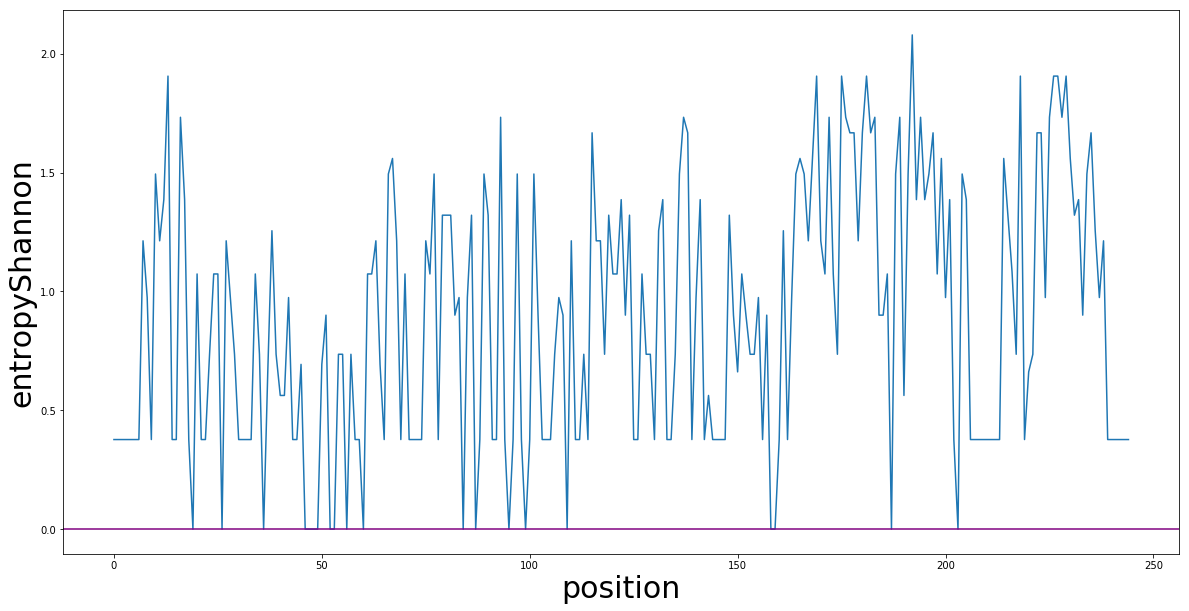

In [82]:
plt.plot(P04483.entropy)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
axhline(0, color='purple')
plt.show()

In [83]:
P04483.scanDomains()
interval = P04483.domains['DNA-binding HTH domain, TetR-type']['interval'][3]
entropie = P04483.entropy[int(interval[0]):int(interval[1])]

step 1/2 : searching domains
scanning finish


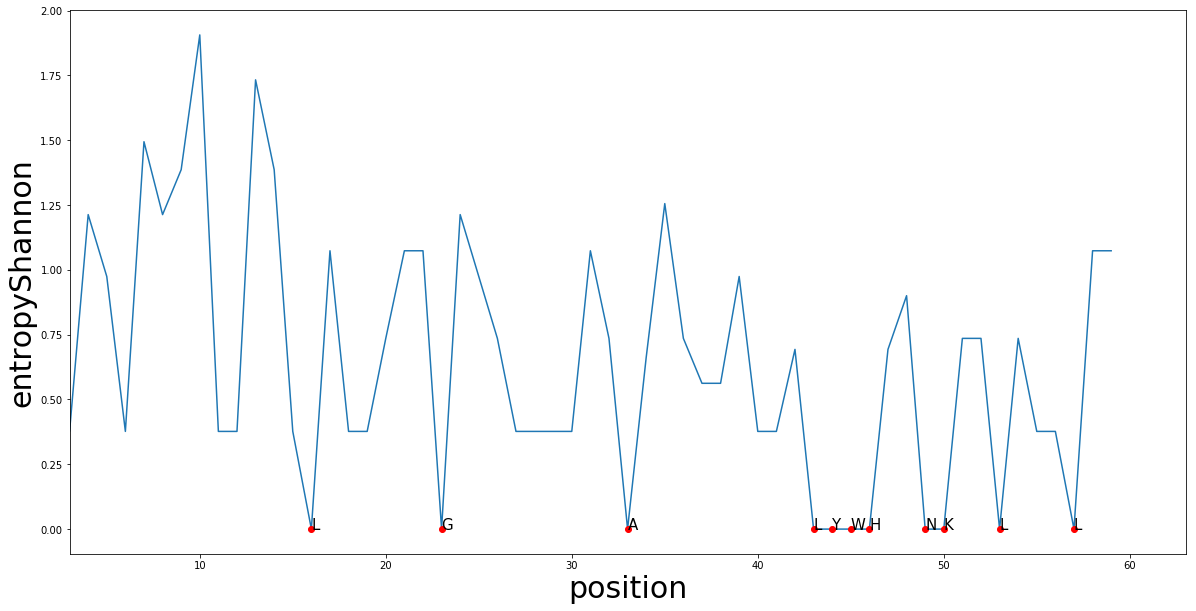

In [84]:
plt.plot(entropie)
plt.xlim(int(interval[0]),int(interval[1]))
for pos,i in enumerate(entropie):
    if i == 0:
        AA = P04483.seq[pos-int(interval[0])]
        xy = (pos, 0)
        plt.plot(xy[0], xy[1], "or")
        plt.annotate(AA, xy=xy, textcoords='data', fontsize=15)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
#axhline(0, color='purple')
plt.show()

# Chimera

Sélection des atomes et/surfaces dans le modèle 0. Ici tout ce qui n’est pas de la tétracycline et tout ce qui est à moins de 5 Å.  
https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/midas/select.html

Écrit un fichier parsable de la sélection. L'option simple permet décrire : residue name, residue specifier, and atom name 
https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/framecommand.html

### Parser de fichier de Chimera

In [85]:
import pyproteins.sequence.peptide as pep
from termcolor import colored, cprint

In [86]:
fileTXT = "/home/antoine/Documents/Stage2019/Stage/my_selection.txt"
f = open(fileTXT, 'r')
AAchimera = []
for line in f.readlines():
    elements = re.search('^#0.1.(?!.*HOH|.*MG).*',line)
    if elements:
        m = elements.string.split(" ")
        AAchimera.append((pep.threeToOne(m[1]), int(m[2].strip().split(".")[0])))
        #print(m[1]+" at "+str(pos[0]))
print(AAchimera)

i = 0
for pos,aa in enumerate(P04483.seq):
    if aa == AAchimera[i][0] and pos == AAchimera[i][1]:
        text = colored(aa,'white', 'on_green')
        i += 1
    if aa == AAchimera[i][0]:
        text = colored(aa,'white', 'on_blue')
        i += 1
    else:
        text = colored(aa, 'yellow')
    print(text, end='')

[('L', 60), ('H', 64), ('S', 67), ('N', 82), ('F', 86), ('H', 100), ('T', 103), ('R', 104), ('P', 105), ('Q', 109), ('T', 112), ('V', 113), ('Q', 116), ('L', 117), ('L', 131), ('I', 134), ('V', 137), ('S', 138), ('L', 170), ('A', 173), ('L', 174), ('M', 177)]
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS

In [9]:
P04483.seq

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

Ci-dessous la séquence de la protéine du pdb 2vkn

### Alignement de séquences protéiques : avec *pyproteins*

In [87]:
import pyproteins.sequence.peptide as pep

p1 = {'id' : "2VKN",
    'desc' : 'seq1 PDB 2vkn',
    'seq' : "MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV"
}
pepPDB = pep.Entry(p1)

p2 = {'id' : "P08843",
    'desc' : 'seq2 P08843',
    'seq' : P04483.seq
}
pepUniProt = pep.Entry(p2)


In [88]:
import pyproteins.alignment.nw_custom as N
import pyproteins.alignment.scoringFunctions as scoringFunctions
import pyproteins.sequence.peptide as pep

blosum = scoringFunctions.Needle().fScore
nw = N.nw(gapOpen=-10, gapExtend=-0.5, matchScorer=blosum)
aliResObj = nw.align(pepPDB, pepUniProt)
print(aliResObj)

#Alignment score 708.0, identity(%) = 67.79, similarity(%) = 77.4
>2VKN
MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS-
>P08843



In [89]:
import pyproteins.alignment.nw_custom

In [90]:
N.viewer(aliResObj)

,,M,S,R,L,D,K,S,K,V,I,N,S,A,L,E,L,L,N,E,V,G,I,E,G,L,T,T,R,K,L,A,Q,K,L,G,V,E,Q,P,T,L,Y,W,H,V,K,N,K,R,A,L,L,D,A,L,A,I,E,M,L,D,R,H,H,T,H,F,C,P,L,E,G,E,S,W,Q,D,F,L,R,N,N,A,K,S,F,R,C,A,L,L,S,H,R,D,G,A,K,V,H,L,G,T,R,P,T,E,K,Q,Y,E,T,L,E,N,Q,L,A,F,L,C,Q,Q,G,F,S,L,E,N,A,L,Y,A,L,S,A,V,G,H,F,T,L,G,C,V,L,E,D,Q,E,H,Q,V,A,K,E,E,R,E,T,P,T,T,D,S,M,P,P,L,L,R,Q,A,I,E,L,F,D,H,Q,G,A,E,P,A,F,L,F,G,L,E,L,I,I,C,G,L,E,K,Q,L,K,C,E,S,G,S
,0.0,-0.5,-1.0,-1.5,-2.0,-2.5,-3.0,-3.5,-4.0,-4.5,-5.0,-5.5,-6.0,-6.5,-7.0,-7.5,-8.0,-8.5,-9.0,-9.5,-10.0,-10.5,-11.0,-11.5,-12.0,-12.5,-13.0,-13.5,-14.0,-14.5,-15.0,-15.5,-16.0,-16.5,-17.0,-17.5,-18.0,-18.5,-19.0,-19.5,-20.0,-20.5,-21.0,-21.5,-22.0,-22.5,-23.0,-23.5,-24.0,-24.5,-25.0,-25.5,-26.0,-26.5,-27.0,-27.5,-28.0,-28.5,-29.0,-29.5,-30.0,-30.5,-31.0,-31.5,-32.0,-32.5,-33.0,-33.5,-34.0,-34.5,-35.0,-35.5,-36.0,-36.5,-37.0,-37.5,-38.0,-38.5,-39.0,-39.5,-40.0,-40.5,-41.0,-41.5,-42.0,-42.5,-43.0,-43.5,-44.0,-44.5,-45.0,-45.5,-46.0,-46.5,-47.0,-47.5,-48.0,-48.5,-49.0,-49.5,-50.0,-50.5,-51.0,-51.5,-52.0,-52.5,-53.0,-53.5,-54.0,-54.5,-55.0,-55.5,-56.0,-56.5,-57.0,-57.5,-58.0,-58.5,-59.0,-59.5,-60.0,-60.5,-61.0,-61.5,-62.0,-62.5,-63.0,-63.5,-64.0,-64.5,-65.0,-65.5,-66.0,-66.5,-67.0,-67.5,-68.0,-68.5,-69.0,-69.5,-70.0,-70.5,-71.0,-71.5,-72.0,-72.5,-73.0,-73.5,-74.0,-74.5,-75.0,-75.5,-76.0,-76.5,-77.0,-77.5,-78.0,-78.5,-79.0,-79.5,-80.0,-80.5,-81.0,-81.5,-82.0,-82.5,-83.0,-83.5,-84.0,-84.5,-85.0,-85.5,-86.0,-86.5,-87.0,-87.5,-88.0,-88.5,-89.0,-89.5,-90.0,-90.5,-91.0,-91.5,-92.0,-92.5,-93.0,-93.5,-94.0,-94.5,-95.0,-95.5,-96.0,-96.5,-97.0,-97.5,-98.0,-98.5,-99.0,-99.5,-100.0,-100.5,-101.0,-101.5,-102.0,-102.5,-103.0,-103.5
M,-0.5,5.0,-1.5,-2.0,0.5,-3.0,-3.5,-4.0,-4.5,-3.0,-3.5,-6.0,-6.5,-5.0,-4.5,-8.0,-5.5,-6.0,-9.5,-10.0,-8.5,-11.0,-9.5,-12.0,-12.5,-10.0,-13.5,-14.0,-14.5,-15.0,-12.5,-14.0,-15.5,-17.0,-14.5,-18.0,-16.5,-19.0,-18.5,-20.0,-20.5,-18.0,-21.5,-22.0,-22.5,-21.0,-23.5,-24.0,-24.5,-25.0,-23.5,-23.0,-23.5,-27.0,-25.5,-25.0,-26.5,-27.0,-29.5,-24.0,-27.5,-31.0,-31.5,-32.0,-32.5,-33.0,-33.5,-33.0,-34.5,-35.0,-32.5,-36.0,-36.5,-37.0,-37.5,-38.0,-37.5,-39.0,-38.5,-37.0,-40.5,-41.0,-41.5,-40.0,-42.5,-43.0,-42.5,-44.0,-44.5,-43.0,-42.5,-43.0,-46.5,-47.0,-47.5,-48.0,-48.5,-47.0,-49.5,-48.0,-50.5,-48.0,-51.5,-52.0,-52.5,-53.0,-53.5,-54.0,-54.5,-54.0,-55.5,-56.0,-56.5,-54.0,-57.5,-58.0,-57.5,-56.0,-57.5,-59.0,-57.5,-61.0,-60.5,-61.0,-62.5,-62.0,-63.5,-61.0,-64.5,-65.0,-63.5,-63.0,-66.5,-65.0,-64.5,-68.0,-66.5,-67.0,-69.5,-70.0,-69.5,-71.0,-68.5,-72.0,-72.5,-71.0,-70.5,-74.0,-74.5,-74.0,-75.5,-76.0,-75.5,-75.0,-75.5,-78.0,-78.5,-79.0,-79.5,-80.0,-80.5,-81.0,-81.5,-82.0,-82.5,-83.0,-77.5,-84.0,-84.5,-82.0,-82.5,-86.0,-85.5,-85.0,-85.5,-88.0,-85.5,-88.0,-89.5,-90.0,-89.5,-91.0,-89.5,-92.0,-92.5,-91.0,-92.5,-91.0,-93.5,-95.0,-92.5,-96.0,-93.5,-95.0,-95.5,-98.0,-98.5,-96.0,-99.5,-100.0,-99.5,-98.0,-101.5,-102.0,-102.5,-103.0,-103.5,-104.0
S,-1.0,-1.5,9.0,-1.0,-1.5,0.5,-3.0,0.5,-4.0,-6.5,-5.0,-2.5,-2.0,-5.5,-7.0,-4.5,-10.0,-7.5,-5.0,-9.5,-12.0,-8.5,-13.0,-9.5,-12.0,-14.5,-9.0,-12.5,-15.0,-14.5,-17.0,-11.5,-14.0,-15.5,-19.0,-14.5,-20.0,-16.5,-19.0,-19.5,-19.0,-22.5,-20.0,-24.5,-23.0,-24.5,-21.0,-22.5,-24.0,-25.5,-24.0,-25.5,-25.0,-23.5,-26.0,-27.5,-24.0,-28.5,-27.0,-30.5,-26.0,-27.5,-32.0,-32.5,-33.0,-31.5,-34.0,-35.5,-34.0,-35.5,-37.0,-32.5,-36.0,-36.5,-33.0,-40.5,-38.0,-37.5,-41.0,-40.5,-38.0,-39.5,-40.0,-40.5,-40.0,-38.5,-45.0,-43.5,-45.0,-43.5,-45.0,-44.5,-39.0,-47.5,-48.0,-47.5,-48.0,-47.5,-47.0,-51.5,-49.0,-52.5,-48.0,-50.5,-53.0,-53.5,-52.0,-53.5,-54.0,-54.5,-56.0,-55.5,-55.0,-58.5,-54.0,-56.5,-58.0,-59.5,-55.0,-59.5,-61.0,-58.5,-61.0,-60.5,-61.0,-64.5,-58.0,-65.5,-61.0,-63.5,-64.0,-65.5,-65.0,-65.5,-67.0,-60.5,-67.0,-68.5,-67.0,-70.5,-72.0,-68.5,-73.0,-68.5,-73.0,-74.5,-73.0,-70.5,-74.0,-74.5,-74.0,-76.5,-76.0,-77.5,-74.0,-75.5,-78.0,-78.5,-80.0,-79.5,-79.0,-81.5,-80.0,-80.5,-82.0,-78.5,-84.0,-78.5,-85.0,-86.5,-84.0,-83.5,-86.0,-84.5,-87.0,-85.5,-90.0,-87.5,-88.0,-90.5,-90.0,-89.5,-90.0,-89.5,-93.0,-91.5,-93.0,-94.5,-93.0,-93

### Parser de PDB

In [250]:
import pyproteinsExt.structure.coordinates as PDB
parser = PDB.Parser()
pdbObj = parser.load(file="/home/antoine/Documents/Stage2019/Stage/2vkv.pdb")
pdbObj.SEQRES

{'A': 'MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV'}

In [251]:
AApdb = [(pep.threeToOne(aa.name), int(aa.num)) for aa in pdbObj.byres()]
AApdb

[('K', 6),
 ('S', 7),
 ('K', 8),
 ('V', 9),
 ('I', 10),
 ('N', 11),
 ('S', 12),
 ('A', 13),
 ('L', 14),
 ('E', 15),
 ('L', 16),
 ('G', 17),
 ('N', 18),
 ('E', 19),
 ('V', 20),
 ('G', 21),
 ('I', 22),
 ('E', 23),
 ('G', 24),
 ('L', 25),
 ('T', 26),
 ('T', 27),
 ('R', 28),
 ('K', 29),
 ('L', 30),
 ('A', 31),
 ('Q', 32),
 ('K', 33),
 ('L', 34),
 ('G', 35),
 ('V', 36),
 ('E', 37),
 ('Q', 38),
 ('P', 39),
 ('T', 40),
 ('L', 41),
 ('Y', 42),
 ('W', 43),
 ('H', 44),
 ('V', 45),
 ('K', 46),
 ('N', 47),
 ('K', 48),
 ('R', 49),
 ('A', 50),
 ('L', 51),
 ('L', 52),
 ('D', 53),
 ('A', 54),
 ('L', 55),
 ('A', 56),
 ('V', 57),
 ('E', 58),
 ('I', 59),
 ('L', 60),
 ('A', 61),
 ('R', 62),
 ('H', 63),
 ('H', 64),
 ('D', 65),
 ('Y', 66),
 ('S', 67),
 ('L', 68),
 ('P', 69),
 ('A', 70),
 ('A', 71),
 ('G', 72),
 ('E', 73),
 ('S', 74),
 ('W', 75),
 ('Q', 76),
 ('S', 77),
 ('F', 78),
 ('L', 79),
 ('R', 80),
 ('N', 81),
 ('N', 82),
 ('A', 83),
 ('M', 84),
 ('S', 85),
 ('F', 86),
 ('R', 87),
 ('R', 88),
 ('A', 8

### Intersection Chiméra et PDB

In [93]:
d = {}
# Attention numérotation informatique pour Uniprot mais numérotation naturel pour les pdb
for pos, aa in enumerate(P04483.seq):
    if pos not in d:
        d[pos] = [aa]
for aa1, pos1 in AApdb:
    d[pos1-1].append(aa1.lower())
for aa2, pos2 in AAchimera:
    d[pos2-1].append(aa2)
print(d)
#1 UniProt ; lower PDB ; 3 Chiméra (upper)

{0: ['M'], 1: ['S'], 2: ['R'], 3: ['L'], 4: ['D'], 5: ['K', 'k'], 6: ['S', 's'], 7: ['K', 'k'], 8: ['V', 'v'], 9: ['I', 'i'], 10: ['N', 'n'], 11: ['S', 's'], 12: ['A', 'a'], 13: ['L', 'l'], 14: ['E', 'e'], 15: ['L', 'l'], 16: ['L', 'g'], 17: ['N', 'n'], 18: ['E', 'e'], 19: ['V', 'v'], 20: ['G', 'g'], 21: ['I', 'i'], 22: ['E', 'e'], 23: ['G', 'g'], 24: ['L', 'l'], 25: ['T', 't'], 26: ['T', 't'], 27: ['R', 'r'], 28: ['K', 'k'], 29: ['L', 'l'], 30: ['A', 'a'], 31: ['Q', 'q'], 32: ['K', 'k'], 33: ['L', 'l'], 34: ['G', 'g'], 35: ['V', 'v'], 36: ['E', 'e'], 37: ['Q', 'q'], 38: ['P', 'p'], 39: ['T', 't'], 40: ['L', 'l'], 41: ['Y', 'y'], 42: ['W', 'w'], 43: ['H', 'h'], 44: ['V', 'v'], 45: ['K', 'k'], 46: ['N', 'n'], 47: ['K', 'k'], 48: ['R', 'r'], 49: ['A', 'a'], 50: ['L', 'l'], 51: ['L', 'l'], 52: ['D', 'd'], 53: ['A', 'a'], 54: ['L', 'l'], 55: ['A', 'a'], 56: ['I', 'v'], 57: ['E', 'e'], 58: ['M', 'i'], 59: ['L', 'l', 'L'], 60: ['D', 'a'], 61: ['R', 'r'], 62: ['H', 'h'], 63: ['H', 'h', 'H'], 

In [120]:
def compar(a,b,c=None):
    if not c:
        if a.upper() == b.upper():
            return True
    else:
        if a.upper() == b.upper() == c.upper():
            return True
    return False

result = {"red":[], "green":[], "yellow":[], "blue":[]}

for pos in d:
    #len 1
    if len(d[pos]) == 1:
        text = d[pos][0].lower()
    #len 2
    elif len(d[pos]) == 2:
        if compar (d[pos][0], d[pos][1]):
            if d[pos][1].isupper():
                text = colored(d[pos][0], 'white', 'on_green')
                result["green"].append((d[pos][0],pos))
            else:
                text = colored(d[pos][0], 'grey', 'on_yellow')
                result["yellow"].append((d[pos][0],pos))
        else:
            text = colored(d[pos][0], 'grey', 'on_red')
            result["red"].append((d[pos][0],pos))
    #len 3
    elif len(d[pos]) == 3:
        #3 match
        if compar(d[pos][0], d[pos][1], d[pos][2]):
            #le [2] est chimera
            text = colored(d[pos][0], 'grey', 'on_green')
            result["green"].append((d[pos][0],pos))
        #2 match
        #PDB & Uniprot
        elif compar(d[pos][0], d[pos][1]):
            if d[pos][1].islower():
                text = colored(d[pos][0], 'grey', 'on_yellow')
                result["yellow"].append((d[pos][0],pos))
            else:
                text = colored(d[pos][0], 'grey', 'on_green')
                result["green"].append((d[pos][0],pos))
        #chimera & Uniprot
        elif compar(d[pos][0], d[pos][2]):
            text = colored(d[pos][0], 'grey', 'on_green')
            result["green"].append((d[pos][0],pos))
        #chimera & PDB
        elif compar(d[pos][1], d[pos][2]):
            text = colored(d[pos][0], 'grey', 'on_blue')
            result["blue"].append((d[pos][0],pos))
        #NO match
        else:
            text = colored(d[pos][0], 'white', 'on_red')
            result["red"].append((d[pos][0],pos))
    print(text, end='')
legend()
print(result["green"])
print(result["blue"])

msrldKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESgs

    perfect Match
    PDB Match
    PDB & Chimera Match, no UniProt
    No Match
[('L', 59), ('H', 63), ('N', 81), ('F', 85), ('H', 99), ('T', 102), ('R', 103), ('P', 104), ('Q', 108), ('T', 111), ('Q', 115), ('L', 116), ('L', 130), ('V', 136), ('L', 169), ('A', 172)]
[('F', 66), ('L', 112), ('L', 133), ('G', 137), ('I', 173), ('F', 176)]


In [95]:
def legend():
    print("\n")
    print(colored(" ", 'white', 'on_green'),"  perfect Match",)
    print(colored(" ", 'white', 'on_yellow'),"  PDB Match")
    print(colored(" ", 'white', 'on_blue'),"  PDB & Chimera Match, no UniProt")
    print(colored(" ", 'white', 'on_red'),"  No Match")

In [236]:
P04483.scanDomains()
P04483.clustal()
P04483.msa(verbose=True)

step 1/2 : searching domains
scanning finish
Index sequence master is 7
pos  1 is E   1 / 8 = 0.125 with height : 0.49947340752552727
pos  1 is M   7 / 8 = 0.875 with height : 3.394078880200541
			entropy = 0.37677016125643675  with height = 3.394078880200541
pos  2 is A   4 / 8 = 0.5 with height : 1.9545719313171124
pos  2 is T   2 / 8 = 0.25 with height : 0.8906425680885631
pos  2 is N   1 / 8 = 0.125 with height : 0.4128300099555341
pos  2 is S   1 / 8 = 0.125 with height : 0.3803387358667867
			entropy = 1.2130075659799042  with height = 1.9545719313171124
pos  3 is L   1 / 8 = 0.125 with height : 0.49947340752552727
pos  3 is K   4 / 8 = 0.5 with height : 1.8246068349621227
pos  3 is R   3 / 8 = 0.375 with height : 1.230526012516818
			entropy = 0.9743147528693494  with height = 1.8246068349621227
pos  4 is K   1 / 8 = 0.125 with height : 0.49947340752552727
pos  4 is L   7 / 8 = 0.875 with height : 3.394078880200541
			entropy = 0.37677016125643675  with height = 3.39407888020054

pos  206 is N   1 / 8 = 0.125 with height : 0.39116916056303586
pos  206 is H   1 / 8 = 0.125 with height : 0.3586778864742884
pos  206 is Q   1 / 8 = 0.125 with height : 0.3261866123855409
pos  206 is G   1 / 8 = 0.125 with height : 0.2936953382967935
			entropy = 1.9061547465398496  with height = 0.9772859656585562
pos  207 is -   2 / 8 = 0.25 with height : 0.9772859656585562
pos  207 is T   2 / 8 = 0.25 with height : 0.8906425680885631
pos  207 is I   2 / 8 = 0.25 with height : 0.80399917051857
pos  207 is V   1 / 8 = 0.125 with height : 0.3695083111705375
pos  207 is S   1 / 8 = 0.125 with height : 0.3370170370817901
			entropy = 1.559581156259877  with height = 0.9772859656585562


In [241]:
P04483.entropyHeight

[3.394078880200541,
 1.9545719313171124,
 1.8246068349621227,
 3.394078880200541,
 1.360491108871808,
 1.9545719313171124,
 1.9545719313171124,
 0.9123034174810614,
 3.394078880200541,
 3.394078880200541,
 0.8473208693035665,
 1.9545719313171124,
 3.621517798821773,
 4.2557174529141975,
 2.476228240397258,
 3.394078880200541,
 3.394078880200541,
 2.8350192793990368,
 2.313771869953521,
 2.313771869953521,
 4.2557174529141975,
 1.9545719313171124,
 1.6407013500224241,
 2.640071634866552,
 3.394078880200541,
 3.394078880200541,
 3.394078880200541,
 3.394078880200541,
 2.313771869953521,
 2.8350192793990368,
 4.2557174529141975,
 2.476228240397258,
 1.360491108871808,
 2.8350192793990368,
 3.0299669239315214,
 3.0299669239315214,
 1.6407013500224241,
 3.394078880200541,
 3.394078880200541,
 1.9545719313171124,
 4.2557174529141975,
 4.2557174529141975,
 4.2557174529141975,
 4.2557174529141975,
 1.9545719313171124,
 2.476228240397258,
 4.2557174529141975,
 4.2557174529141975,
 2.83501927939

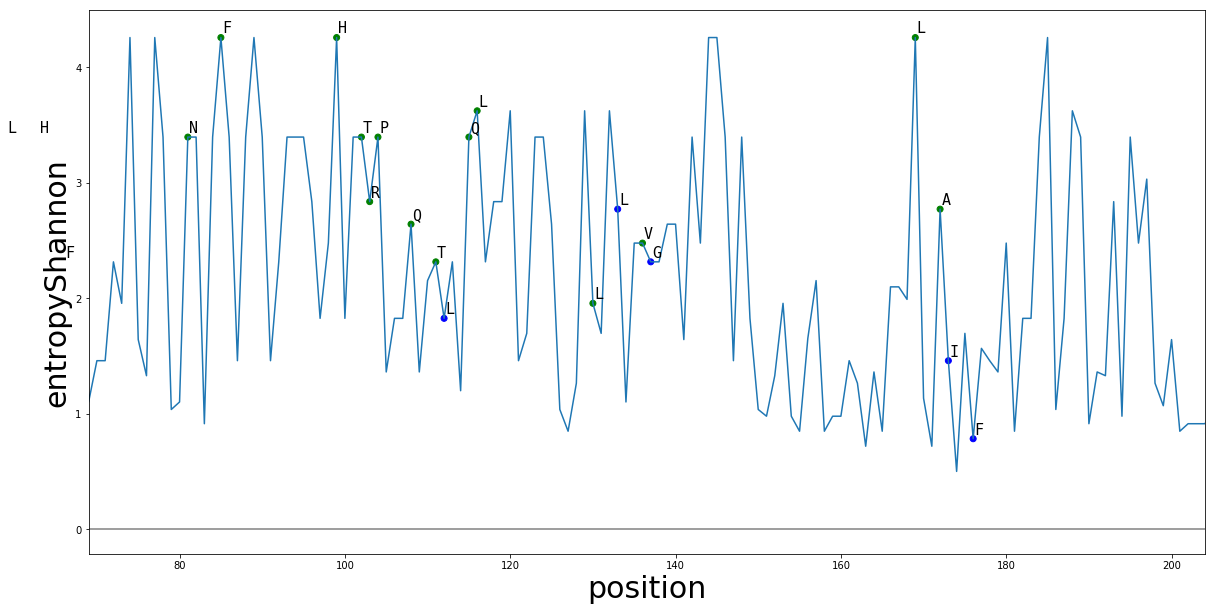

In [249]:
#entropie = P04483.entropy[int(interval[0]):int(interval[1])]
#entropie = P04483.entropy
entropie = P04483.entropyHeight
plt.plot(entropie)
interval = P04483.domains['Tetracyclin repressor-like, C-terminal domain superfamily']['interval'][0]
#interval = (0,len(entropie))
plt.xlim(int(interval[0]),int(interval[1]))
#plt.xlim(30,80)
colors = []
AAlist = []
xy = {"x": [] , "y" : []}

"""for pos,i in enumerate(entropie):
    if i == 0:
        AA = P04483.seq[pos-int(interval[0])]
        xy["x"].append(pos)
        xy ["y"].append(0)
        colors.append('magenta')
        plt.text(pos, 0, AA, fontsize=12, position=(pos-0.5, entropie[pos]-0.07), fontname='monospace', color = 'grey')
    else:
        AA = P04483.seq[pos-int(interval[0])]
        xy = (pos, entropie[pos])
        plt.plot(xy[0], xy[1])
        plt.annotate(AA, xy=xy, textcoords='data', fontsize=15)"""
        
for color in result:
    if color in ["green", "blue"]:
        duo = result[color]
        for aa, pos in duo:
            #AAlist.append(aa)
            xy["x"].append(pos)
            xy ["y"].append(entropie[pos])
            colors.append(color)
            plt.text(pos, entropie[pos], aa, fontsize=15, position=(pos+0.15, entropie[pos]+0.04), fontname='monospace')
plt.scatter("x","y", data=xy, c=colors)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
axhline(0, color='grey')
plt.show()

## La totale

In [12]:
P0ACS9.scanDomains()
P04483.scanDomains()
P0A0N4.scanDomains()
Q9AIU0.scanDomains()

step 1/2 : searching domains
scanning finish
step 1/2 : searching domains
scanning finish
step 1/2 : searching domains
scanning finish
step 1/2 : searching domains
scanning finish


In [28]:
#Réalisation d'un blast
P0ACS9.homology()
P04483.homology()
P0A0N4.homology()
Q9AIU0.homology()
P0ACS9.clustal()
P04483.clustal()
P0A0N4.clustal()
Q9AIU0.clustal()

File already exist
File already exist
File already exist
File already exist


True

In [14]:
P0ACS9.domains2WebLogo()
P04483.domains2WebLogo()
P0A0N4.domains2WebLogo()
Q9AIU0.domains2WebLogo()

scan of doamins has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-28-58.png

DNA-binding_HTH_domain,_TetR-type-10-70.png

Transcription_regulator_MAATS,_C-terminal-84-202.png

Homeobox-like_domain_superfamily-1-68.png

Tetracyclin_repressor-like,_C-terminal_domain_superfamily-84-200.png

PTHR30055:SF173-1-212.png

PTHR30055-1-212.png

G3DSA:1.10.357.10-1-215.png

	That'all ✔

scan of doamins has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-21-52.png

DNA-binding_HTH_domain,_TetR-type-3-63.png

Tetracycline_repressor_TetR,_C-terminal-69-201.png

Tetracycline_transcriptional_regulator,_TetR-21-197.png

Homeobox-like_domain_superfamily-5-67.png

Tetracyclin_repressor-like,_C-terminal_domain_superfamily-69-204.png

G3DSA:1.10.10.60-1-66.png

G3DSA:1.10.357.10-67-203.png

	That'all ✔

scan of doamins has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-19-49.png

DNA-binding_HTH_domain,_TetR-type-1-61.png

Transcription_regulator_QacR,_C-terminal-57-188.png

Homeobo